In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pandas as pd
from numba import njit,jit

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 19

import os
import subprocess

file reading and organizing functions 

In [2]:
def read_dat_file_diff_alig(filename):
    params = {}
    
    # Read the .dat file
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.split()
            params[key] = value
      
    # Format the output string
    output_string = (
        f"particle_positions_Dt_{params['Dt']}_Nparticles_{params['Nparticles']}_R_{params['R']}_T_{params['T']}_Vo_{params['Vo']}_aligstr_{params['aligstr']}_aligstrmin_{params['aligstrmin']}_box_{params['box']}_cutoff_{params['cutoff']}_epsilon_{params['epsilon']}_eta_{params['eta']}_sigma_{params['sigma']}"
    )
    
    return output_string,params

def read_dat_file_OP_diff_alig(filename):
    params = {}
    
    # Read the .dat file
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.split()
            params[key] = value
    
    # Format the output string
    output_string = (
        f"squared_disp_Dt_{params['Dt']}_Nparticles_{params['Nparticles']}_R_{params['R']}_T_{params['T']}_Vo_{params['Vo']}_aligstr_{params['aligstr']}_aligstrmin_{params['aligstrmin']}_box_{params['box']}_cutoff_{params['cutoff']}_epsilon_{params['epsilon']}_eta_{params['eta']}_sigma_{params['sigma']}"
    )
    
    return output_string


def organize_diff_align(params_file):

    file_name,params = read_dat_file_diff_alig(params_file)
    OP_str = read_dat_file_OP_diff_alig(params_file)
    os.makedirs(file_name,exist_ok=True)

    N=int(params['Nparticles'])
    T = int(params['T'])

    command = f"mv *{file_name[19:]}.dat {file_name}"
    subprocess.run(command,shell=True)

    return file_name,params,N,OP_str,T

def plot_OP(file_name,OP_str,label):

    datamsd=np.loadtxt(f'{file_name}/'+OP_str+'.dat')
    time = datamsd[:,0]
    sq_p = datamsd[:,1]
    fig,ax = plt.subplots()

    ax.plot(time,sq_p, lw=1.1, color='red',label = label)
    # ax.set_xlabel('time')
    # ax.set_ylabel(r'$|\overrightarrow{P}|$')
    # ax.set_ylim(0,1)
    # ax.legend(fontsize=12)
    plt.tight_layout()
    # plt.savefig(f'{file_name}/OP_vs_time.png',dpi=200,bbox_inches="tight")
    # plt.savefig(f'{file_name}/OP_vs_time.pdf',dpi=200,bbox_inches="tight")
    # plt.show()
    
    return ax

def read_positions(filename,N): 
    data= np.loadtxt(filename)
    X = data[:,0]
    Y = data[:,1]
    Theta = data[:,2]
    Steps = len(X) //N 
    X = np.reshape(X,(Steps,N))
    Y = np.reshape(Y,(Steps,N))
    Theta = np.reshape(Theta,(Steps,N))
    return X,Y,Theta


Return times, plot distribution and fit

In [3]:
def return_time(data, tmax, threshold):
    
    """
    Calculate the return time distribution for a given dataset.

    Parameters:
    data (array-like): A 1D array of the order parameter.
    tmax (int): The maximum time to consider.
    threshold (float): The threshold value to determine return times.

    Returns:
    list: A list of return times.
    """
    return_times = []
    
    
    for t in range(tmax - 1):
        
        # print(data[t],data[t-1],data[t+1],threshold,t)
        # if (data[t] < threshold and data[t-1] <= threshold): 
        #     continue
        # start = 0
        # finish = 0
        # if data[0] < threshold:
        #     start = 0
        
        if t == 0:
            if data[t] < threshold:
                start = 0
        else:
            if data[t] < threshold and data[t - 1] >= threshold:
                start = t
            if data[t] < threshold and data[t + 1] >= threshold:
                finish = t
                # print(start,finish)
                return_times.append(finish - start + 1)
            # return_times.append(finish - start + 1)
    return return_times


def plot_return_time_distribution(return_times, ax=None, no_bins=None, label=None):
    """
    Plot the return time distribution given an array of return times.

    Parameters:
    return_times (array-like): Array of return times.
    ax (matplotlib.axes.Axes): Existing axes to plot on. If None, a new figure and axes are created.
    no_bins (int): Number of bins for the histogram. Default is 7.
    """
    if ax is None:
        fig, ax = plt.subplots()

    return_times = np.array(return_times)
    if len(return_times) == 0:
        print('No return times found')
        return ax

    count = len(return_times)
    no_bins = np.ceil(np.log2(count) + 1).astype(int) if no_bins is None else no_bins  # use Sturges' rule if no_bins is not specified
    bins = np.logspace(np.log10(2), np.log10(return_times.max()), no_bins)
    freq, edges = np.histogram(return_times, bins=bins, density=True)
    bin_centers = (edges[1:] + edges[:-1]) / 2
    raw_counts, _ = np.histogram(return_times, bins=bins)
    bin_widths = np.diff(edges)
    p = raw_counts / count / bin_widths
    # fact = raw_counts[0] / freq[0] * (edges[1:] - edges[:-1]) / (edges[1] - edges[0])

    err = np.sqrt(p * (1 - p) / count) / bin_widths

    # bin_centerss = np.linspace(min(bin_centers), max(bin_centers), 101)
    # print('Powerlaw exponent =', -1 - alpha)
    ax.errorbar(bin_centers,freq,yerr=err,capsize=4.5,lw=0,elinewidth=1,marker='o',color='black',mfc='none',ms=7)
    # ax.bar(bin_centers,freq,width=2.5)
    ax.set_xlabel('return times')
    ax.loglog()

    # ax.plot(bin_centers, raw_counts / fact, 'o-', color='blue')
    return ax, bin_centers,freq,err


def powerlaw_fit(data):
    """
    Fit a power-law distribution to the data.

    Parameters:
    data (array-like): Data to fit.

    Returns:
    float: The fitted power-law exponent.
    """
    x_m = min(data)
    alpha = len(data) / (np.sum(np.log(data / x_m)))
    return x_m, alpha

def powerlaw(x, x_m, alpha):
    """
    Calculate the power-law distribution. x_m and alpha are obtained from the powerlaw_fit function.
    :param x:
    :param x_m:
    :param alpha:
    :return:
    """
    return alpha * x_m ** alpha / x ** (alpha+1)

In [4]:
def read_dat_file(filename):
    params = {}
    
    # Read the .dat file
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.split()
            params[key] = value
      
    # Format the output string
    output_string = (
        f"particle_positions_Dt_{params['Dt']}_Nparticles_{params['Nparticles']}_R_{params['R']}_T_{params['T']}_Vo_{params['Vo']}_aligstr_{params['aligstr']}_box_{params['box']}_cutoff_{params['cutoff']}_epsilon_{params['epsilon']}_eta_{params['eta']}_sigma_{params['sigma']}"
    )
    
    return output_string,params

def read_dat_file_OP(filename):
    params = {}
    
    # Read the .dat file
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.split()
            params[key] = value
    
    # Format the output string
    output_string = (
        f"squared_disp_Dt_{params['Dt']}_Nparticles_{params['Nparticles']}_R_{params['R']}_T_{params['T']}_Vo_{params['Vo']}_aligstr_{params['aligstr']}_box_{params['box']}_cutoff_{params['cutoff']}_epsilon_{params['epsilon']}_eta_{params['eta']}_sigma_{params['sigma']}"
    )
    
    return output_string

Velocity correlation fluctuation

In [5]:
from numba import njit, prange



@njit(parallel=True)
def compute_correlations(X, Y, Theta, bins, box):
    T, N = X.shape
    V = np.exp(1j * Theta)
    V_avg = np.sum(V, axis=-1) / N
    V_avg = V_avg.reshape(-1, 1)
    
    V_fluc = V - V_avg
    ux = np.real(V_fluc)
    uy = np.imag(V_fluc)

    num_bins = len(bins) - 1
    C = np.zeros((N, num_bins))
    counts = np.zeros((N, num_bins))

    for i in prange(N):
        for j in range(i + 1, N):
            dx = np.abs(X[:, i] - X[:, j])
            dx = np.minimum(dx, box - dx)
            dy = np.abs(Y[:, i] - Y[:, j])
            dy = np.minimum(dy, box - dy)
            l = np.sqrt(dx**2 + dy**2)

            for t in range(T):
                if l[t] >= bins[0] and l[t] < bins[-1]:
                    bin_index = np.searchsorted(bins, l[t]) - 1
                    if bin_index >= 0 and bin_index < num_bins:
                        C[i, bin_index] += ux[t, i] * ux[t, j] + uy[t, i] * uy[t, j]
                        counts[i, bin_index] += 1

    Ctotal = np.sum(C, axis=0)
    countss = np.sum(counts, axis=0)
    return Ctotal, countss




def velocity_fluctuation_correlation(X,Y,Theta,bins,box):
    C,counts = compute_correlations(X,Y,Theta,bins,box)
    Cs = np.divide(C, counts, out=np.zeros_like(C), where=counts > 0)
    Cs = np.ma.masked_where(counts == 0, Cs)
    return Cs/Cs[0]


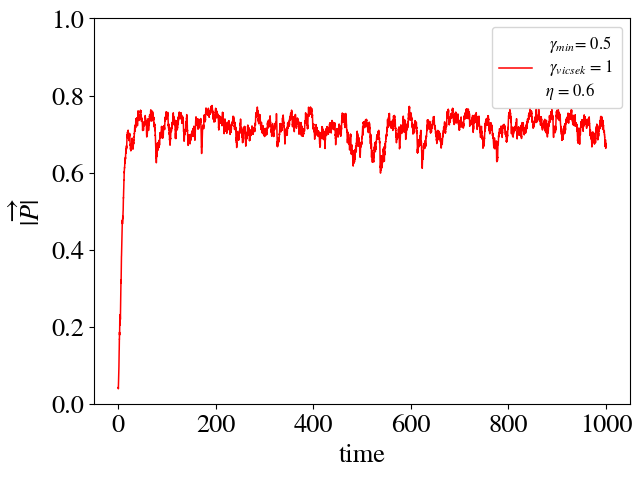

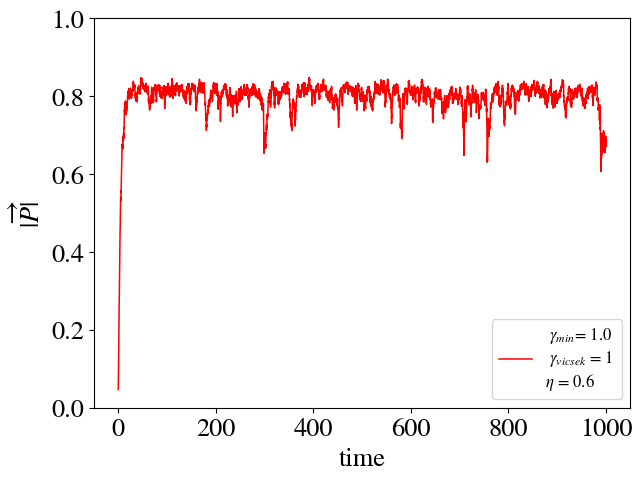

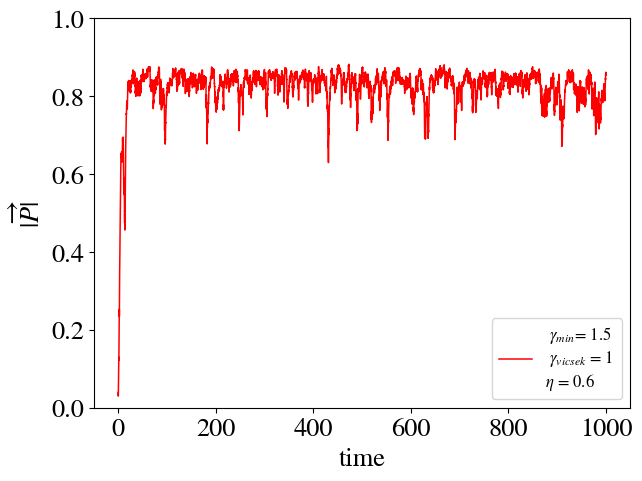

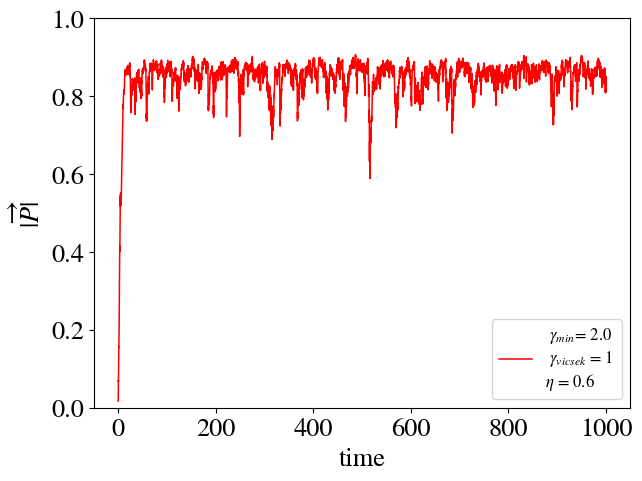

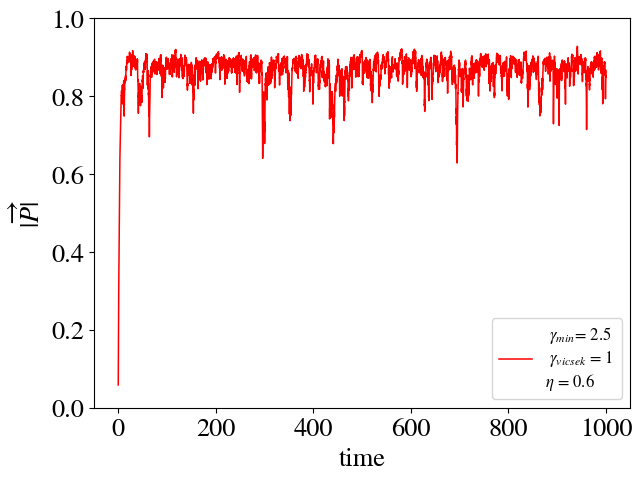

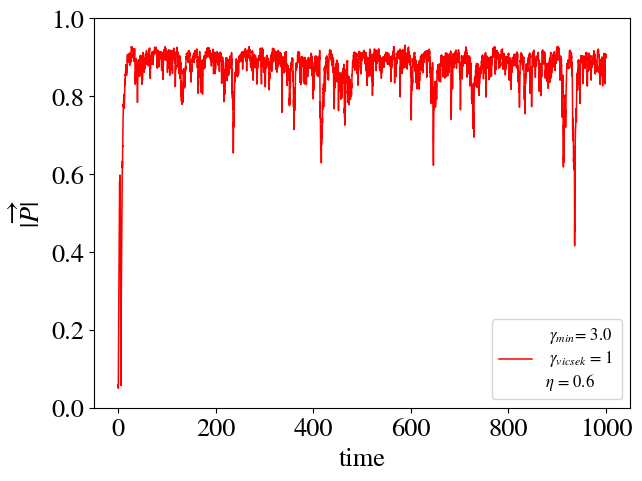

In [10]:

aligns = np.arange(0.5,3.5,0.5)

for align in aligns: 
    filename,params = read_dat_file_diff_alig(f'params_alignmin_{align}.dat')
    # organize_diff_align(f'params_alignmin_{align}.dat')
    op_name = read_dat_file_OP_diff_alig(f'params_alignmin_{align}.dat')
    vicsek_align = params['aligstr']
    eta = params['eta']
    ax = plot_OP(filename,op_name,r' $\gamma_{min}$' + f'= {align} \n' + r' $\gamma_{vicsek}$' + f' = {vicsek_align} \n'+ fr'$\eta$ = {eta}')
    ax.legend(fontsize=12)
    ax.set_xlabel('time')
    ax.set_ylabel(r'$|\overrightarrow{P}|$')
    ax.set_ylim(0,1)
    

# finize-size analysis

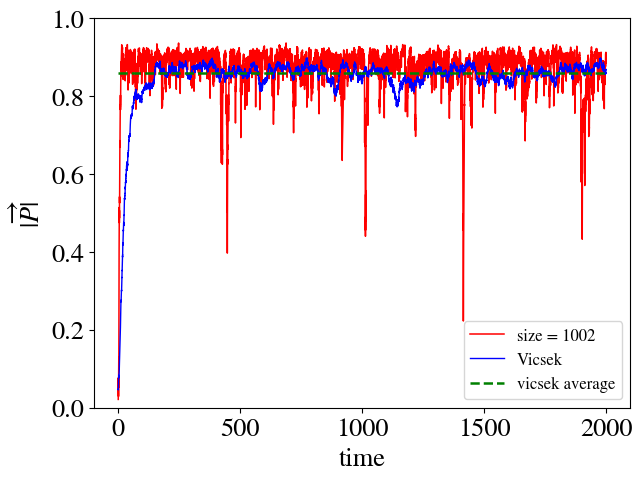

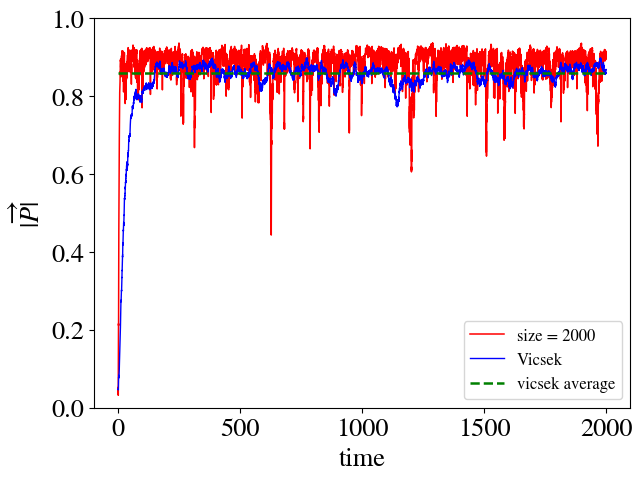

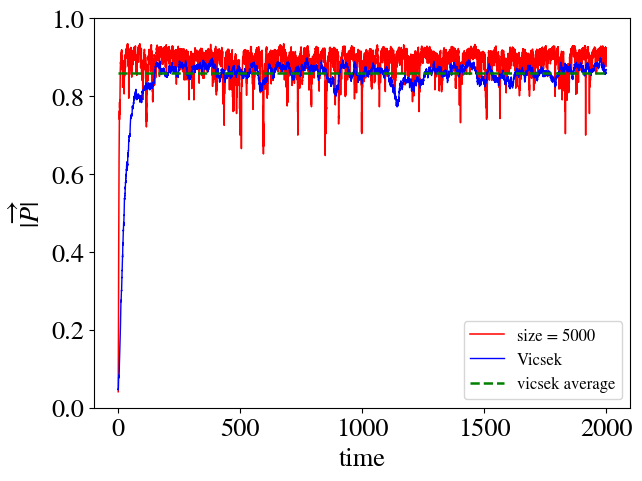

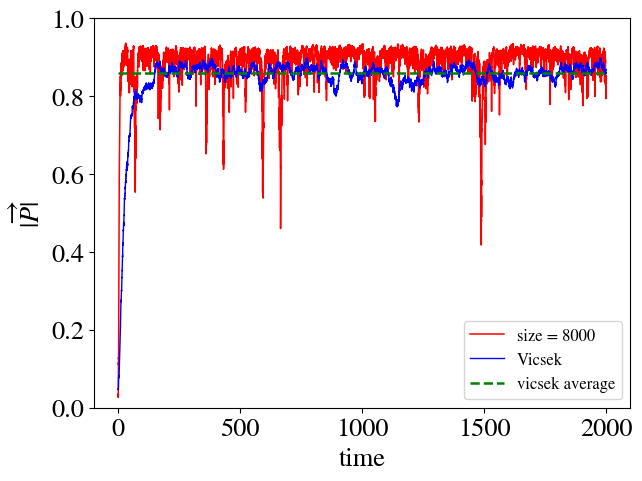

In [7]:

sizes = [1002,2000,5000,8000]

filename_vicsek,params_vicsek= read_dat_file('../../vicsek/params4.dat')
OP_str_vicsek = read_dat_file_OP('../../vicsek/params4.dat')
time_viscek,op_viscek =np.loadtxt(f'../../vicsek/'+OP_str_vicsek+'.dat',unpack=True,usecols=(0,1))
mask = time_viscek > 170
op_viscek_mean = np.mean(op_viscek[mask])

for size in sizes: 
    params_file = f"params_size_{size}.dat"
    filename,params = read_dat_file_diff_alig(params_file)
 
    op_name = read_dat_file_OP_diff_alig(params_file)
    ax = plot_OP(filename,op_name,f'size = {size}')
    ax.plot(time_viscek,op_viscek,lw=1, color='blue',label = f'Vicsek')
    ax.hlines(op_viscek_mean,0,2000,lw=1.8,ls='--',label='vicsek average',color='green')

    
    ax.set_xlabel('time')
    ax.set_ylabel(r'$|\overrightarrow{P}|$')
    ax.set_ylim(0,1)
    ax.legend(fontsize=12)

    plt.show()
    

## Avalanche times

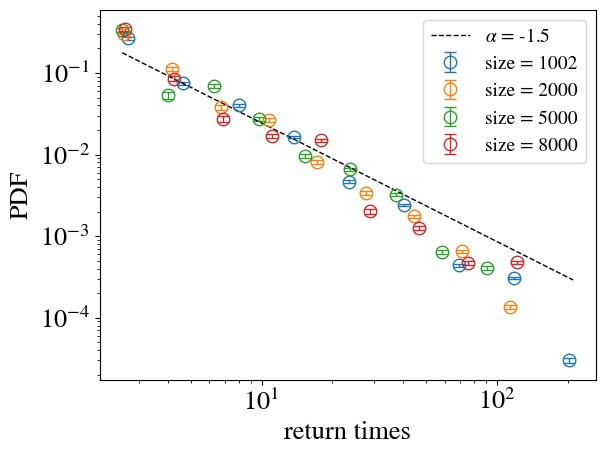

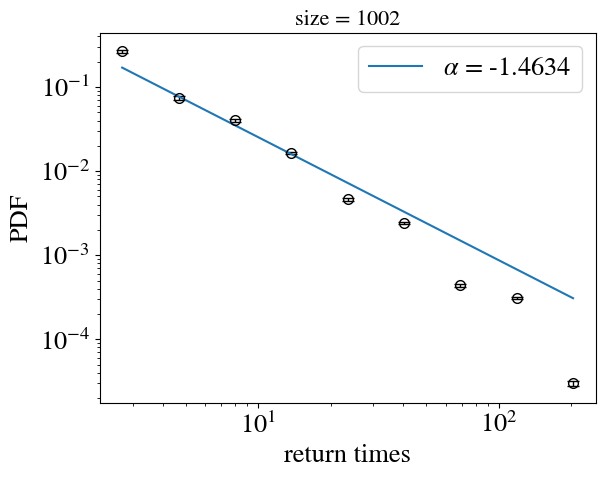

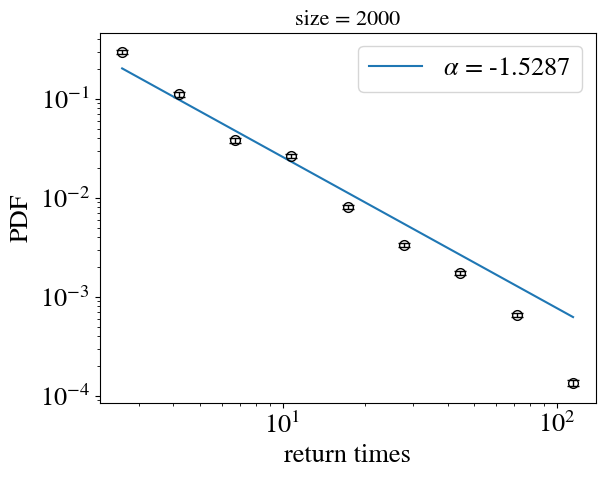

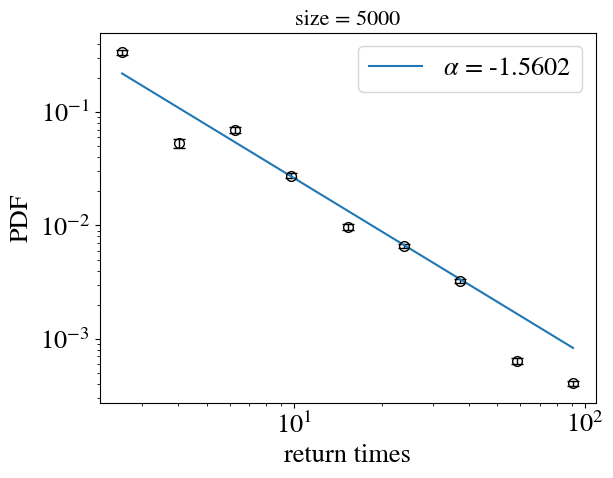

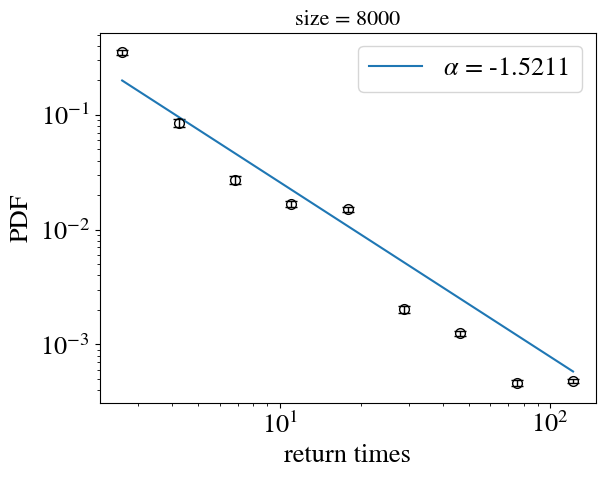

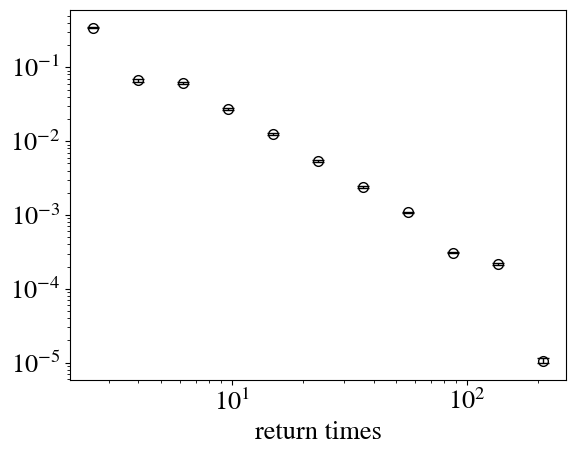

In [8]:
filename_vicsek,params_vicsek= read_dat_file('../../vicsek/params4.dat')
OP_str_vicsek = read_dat_file_OP('../../vicsek/params4.dat')
time_viscek,op_viscek =np.loadtxt(f'../../vicsek/'+OP_str_vicsek+'.dat',unpack=True,usecols=(0,1))
mask = time_viscek > 170
op_viscek_mean = np.mean(op_viscek[mask])

fig2,ax2 = plt.subplots()

all_times= []

for i,size in enumerate(sizes):
    params_file = f"params_size_{size}.dat"
    filename,params = read_dat_file_diff_alig(params_file)
    op_name = read_dat_file_OP_diff_alig(params_file)
    time,op = np.loadtxt(f'{filename}/{op_name}.dat',usecols=(0,1),unpack=True)
    return_times = return_time(op,len(op),op_viscek_mean)
    all_times += return_times
    ax,bins_centers,freq,err = plot_return_time_distribution(return_times,no_bins=None)
    x_m, alpha = powerlaw_fit(bins_centers)

    x = np.logspace(np.log10(bins_centers[0]), np.log10(bins_centers[-1]), 101, endpoint=True)
    y = powerlaw(x,x_m,alpha)
    ax.set_title(f'size = {size}',fontsize=16)
    ax.plot(x,y,label=fr'$\alpha$ = {-1 - alpha:.4f} ')
    ax.legend()
    ax.set_ylabel('PDF')

    # plt.show()
    
    ax2.errorbar(bins_centers,freq,yerr=err,capsize=4.5,lw=0,elinewidth=1,marker='o',mfc='none',ms=9,label=f'size = {size}')

# x1 = np.logspace(np.log10(1), np.log10(200), 101, endpoint=True)

_,bins_centers_all,freq_all,err_all = plot_return_time_distribution(all_times,no_bins=None)
all_x_m,all_alpha = powerlaw_fit(bins_centers_all)
x1 = np.logspace(np.log10(bins_centers_all[0]), np.log10(bins_centers_all[-1]), 101, endpoint=True)
y1 = powerlaw(x1,all_x_m,all_alpha)
ax2.plot(x1,y1,lw=1,ls='--',color='black',label=fr'$\alpha$ = {-1-all_alpha:.1f}')   
ax2.legend(fontsize=14)
ax2.set_ylabel('PDF')
ax2.set_xlabel('return times')
ax2.loglog()

plt.show()
    
    


# Velocity Fluctuation Correlation 

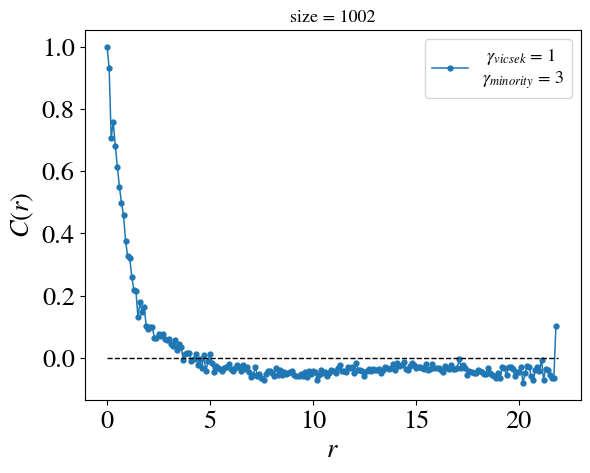

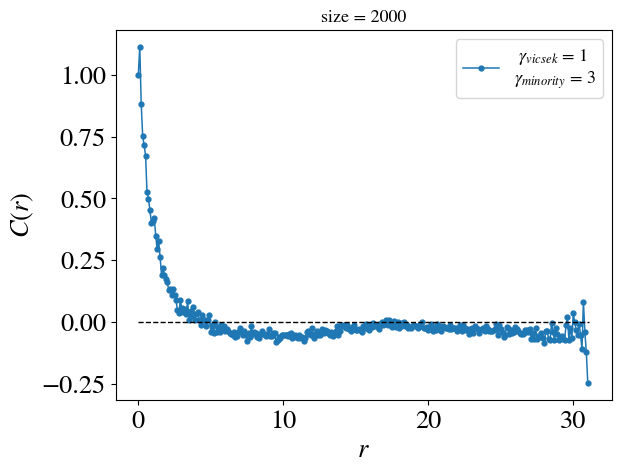

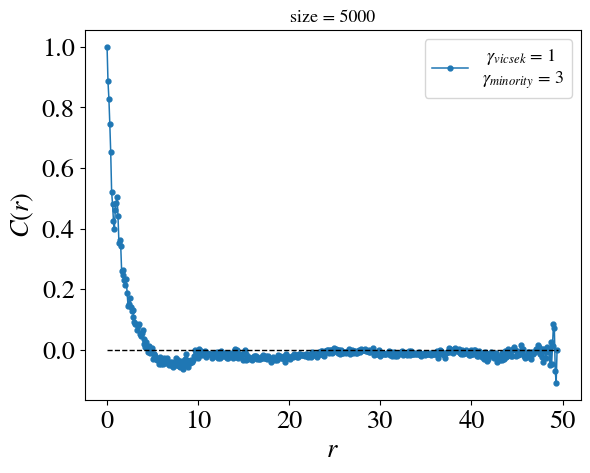

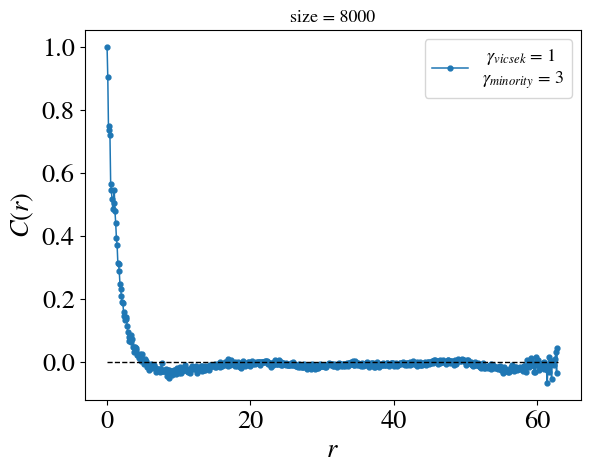

In [9]:

for size in sizes: 
    
    params_file = f"params_size_{size}.dat"
    filename,params = read_dat_file_diff_alig(params_file)
    pos_name = f'{filename}/'+ filename + '.dat'
    N = int(params['Nparticles'])
    
    X,Y,Theta = read_positions(pos_name,N)

    R = int(params['R'])
    box = int(params['box'])
    dr = R/10
    rs = np.arange(0, np.sqrt(2)*box/2 +dr/2,dr )
    C = velocity_fluctuation_correlation(X,Y,Theta,rs,box)
    fig,ax = plt.subplots()
    align = params['aligstr']
    align_min = params['aligstrmin']
    ax.plot(rs[:-1],C,label= r' $\gamma_{vicsek}$ = ' + f'{align}\n' + r'$\gamma_{minority}$ = ' + f'{align_min}',marker='o',lw=1.1,ms=3.5)
    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$C(r)$')

    ax.hlines(0,0,rs.max(),colors='black', ls='--',lw=1.0)
    ax.legend(fontsize=13)
    ax.set_title(f'size = {size}',fontsize=13)
    


    # ax.semilogy()
    plt.show()
   
    